# Principal Component Analysis As A Factor Model

## Introduction
Principal component analysis (PCA) is a statistical technique which enjoys applications in image processing and quantitative finance.
In this article, we focus on the later application in quantitative trading, in particular using PCA as a multi-factor model of portfolio returns.
We use the multi-factor model to design a momentum trading strategy, backtest it under different investment universes, and present the performance results.

The project is shared on my online repository https://github.com/DinodC/pca-factor-model.

Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt

Magic

In [2]:
%matplotlib inline

## Data Collection
In this section, we collect S&P consittuents' historical data from a previous project https://quant-trading.blog/2019/06/24/backtesting-a-trading-strategy-part-2/.

Set S&P Index keys

In [3]:
keys = ['sp500',
        'sp400',
        'sp600']

Initialize S&P indices close data

In [4]:
close = {}

Pull S&P indices close data

In [5]:
for i in keys: 
    # Load OHLCV data
    with open(i + '_data.pickle', 'rb') as f:
        data = pickle.load(f)
    
    # Update close prices data
    close[i] = data.close.loc['2014-06-12':]
    
    # Close file
    f.close

Inspect S&P 500 index constituents data

In [6]:
close['sp500'].head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-12,39.7726,38.2958,123.2252,84.5860,44.6031,65.9975,23.03,35.7925,74.5018,66.56,...,25.8547,41.1019,83.8928,46.4230,28.5372,35.2780,51.2950,101.0367,27.7535,30.8448
2014-06-13,39.8407,38.4672,123.7407,83.6603,45.0187,66.2930,22.95,35.7745,74.7820,66.82,...,25.8884,41.6091,84.7098,46.3744,28.4920,36.0532,51.5945,101.2861,27.8192,30.9702
2014-06-16,39.7181,39.1150,124.0086,84.5035,44.8857,66.0529,23.27,35.8734,74.8634,67.62,...,26.0740,41.9028,84.9326,46.4424,28.3791,35.9318,51.5099,100.7105,27.4060,30.9798
2014-06-17,40.0927,39.8867,124.9411,84.3935,45.1351,66.2561,23.43,35.8375,74.5832,67.54,...,26.0910,42.2409,84.5200,46.2677,28.8310,36.0346,51.7639,100.4707,27.9601,31.6355
2014-06-18,40.3651,40.6392,128.6809,84.4852,45.3595,66.5886,23.37,36.2960,74.7459,73.08,...,26.7810,42.1964,84.7758,46.3841,28.7406,36.3521,51.8876,101.7178,27.9977,31.7126


For WordPress

In [7]:
close['sp500'].iloc[:5, :5]

Symbols,A,AAL,AAP,AAPL,ABBV
date,,,,,
2014-06-12,39.7726,38.2958,123.2252,84.5860,44.6031
2014-06-13,39.8407,38.4672,123.7407,83.6603,45.0187
2014-06-16,39.7181,39.1150,124.0086,84.5035,44.8857
2014-06-17,40.0927,39.8867,124.9411,84.3935,45.1351
2014-06-18,40.3651,40.6392,128.6809,84.4852,45.3595


In [8]:
close['sp500'].tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,67.95,29.12,154.61,179.64,76.75,82.21,267.06,77.46,177.97,268.71,...,57.78,106.90,73.59,54.40,33.30,77.40,106.97,117.41,44.40,108.12
2019-06-05,68.35,30.36,154.61,182.54,77.06,81.65,268.80,78.69,179.56,272.86,...,59.32,105.60,72.98,55.38,33.42,78.88,107.29,118.54,44.18,108.50
2019-06-06,69.16,30.38,154.90,185.22,77.07,81.75,269.19,80.09,180.40,274.80,...,59.80,106.01,74.31,55.63,34.03,79.15,108.42,120.31,44.24,108.89
2019-06-07,69.52,30.92,155.35,190.15,77.43,83.48,267.87,80.74,182.92,278.16,...,59.43,107.49,74.58,55.94,34.16,79.56,109.07,120.73,43.64,110.06
2019-06-10,70.29,30.76,153.52,192.58,76.95,84.77,272.43,81.27,184.44,280.34,...,59.26,110.88,74.91,57.10,34.69,80.38,108.65,121.71,43.84,110.22


For WordPress

In [9]:
close['sp500'].iloc[-6:-1, :5]

Symbols,A,AAL,AAP,AAPL,ABBV
date,,,,,
2019-06-03,66.99,27.20,153.17,173.30,75.70
2019-06-04,67.95,29.12,154.61,179.64,76.75
2019-06-05,68.35,30.36,154.61,182.54,77.06
2019-06-06,69.16,30.38,154.90,185.22,77.07
2019-06-07,69.52,30.92,155.35,190.15,77.43


In [10]:
close['sp500'].describe()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,...,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.00000,1257.000000,1257.000000
mean,52.020384,41.208459,145.434801,135.133436,66.670458,84.568308,162.852343,49.123858,118.508010,142.302737,...,39.362328,58.865112,75.435801,53.179431,26.876008,51.309177,66.614527,111.70591,36.711273,59.821177
std,13.868035,6.368716,24.131106,38.117633,17.717831,9.473348,116.557311,12.652720,31.178171,70.409857,...,8.317325,22.243159,4.713198,7.834761,3.222998,16.350151,15.998532,9.92955,10.738373,20.214756
min,32.258600,24.539800,79.168700,82.743800,42.066600,65.718100,22.220000,33.935700,68.852300,60.880000,...,25.247700,32.502600,58.967500,34.178400,18.532600,28.874500,44.181800,89.23610,18.885300,30.652000
25%,39.391500,36.574400,132.526400,103.637500,53.175300,77.745400,80.700000,39.410700,92.630500,82.100000,...,31.489100,42.116300,72.522500,48.734500,24.214700,35.032500,53.061000,103.35200,26.823800,44.771300
50%,46.123400,40.847900,150.479700,119.476200,58.475100,83.862300,118.580000,43.045400,112.149800,107.970000,...,39.059500,52.731200,75.815100,54.533600,26.571900,48.112000,61.584700,112.77000,38.252800,51.338500
75%,65.603800,46.127100,161.921100,167.857700,82.898700,89.855500,261.940000,58.174900,149.608800,212.280000,...,45.463000,68.820200,78.488900,59.653000,29.655300,67.341800,80.207700,119.13230,46.435300,80.866200
max,81.940000,57.586600,199.159900,229.392000,116.445400,107.649700,449.750000,81.270000,184.440000,289.250000,...,59.800000,139.263300,86.137400,67.795300,35.000000,83.549000,109.070000,130.91280,57.139500,110.220000


For WordPress

In [11]:
close['sp500'].describe().iloc[:, :5]

Symbols,A,AAL,AAP,AAPL,ABBV
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,52.020384,41.208459,145.434801,135.133436,66.670458
std,13.868035,6.368716,24.131106,38.117633,17.717831
min,32.258600,24.539800,79.168700,82.743800,42.066600
25%,39.391500,36.574400,132.526400,103.637500,53.175300
50%,46.123400,40.847900,150.479700,119.476200,58.475100
75%,65.603800,46.127100,161.921100,167.857700,82.898700
max,81.940000,57.586600,199.159900,229.392000,116.445400


In [12]:
close['sp500'].shape

(1257, 505)

Fill NaNs with previous observation

In [13]:
close['sp500'].fillna(method='ffill', inplace=True)
close['sp400'].fillna(method='ffill', inplace=True)
close['sp600'].fillna(method='ffill', inplace=True)

Initialize daily returns

In [14]:
returns = {}

Calculate daily returns

In [15]:
for i in keys:
    returns[i] = close[i].pct_change()

## Momentum Strategy Implementation
In this section, we present the model (factor model) and tool (principal compenent analysis) used in implementing the momentum trading strategy. 

### 1. Factor Models
Factor models use economic (e.g. interest rates), fundamental (e.g. price per earnings), and statistical (e.g. principal component analysis) factors to explain asset prices (and returns).
Fama and French initially designed the [three-factor model](https://en.wikipedia.org/wiki/Fama–French_three-factor_model) which extends the capital asset pricing model (CAPM) to include size and value factors.
The general framework is known as the [arbitrage pricing theory (APT)](https://en.wikipedia.org/wiki/Arbitrage_pricing_theory) developed by Stephen Ross and proposes multiple factors. 

### 2. Principal Component Analysis (PCA)
Principal component analysis is a statistical procedure for finding patterns in high dimension data.
PCA allows you to compress high dimension data by reducing the number of dimensions, without losing much information.
Principal component analysis has the following applications in quantitative finance: interest-rate modeling and portfolio analysis.

PCA implementation has the following steps:
1. Pull data
2. Adjust data by subtracting the mean
3. Calculate the covariance matrix of the adjusted data
4. Calculate the eigenvectors and eigenvalues of the covariance matrix
5. Choose the most significant components which explain around 95% of the data

Note that in this article we are only interested in applying principal component analysis, for a complete illustration you can start by checking out https://en.wikipedia.org/wiki/Principal_component_analysis#Applications.

### 3. Momentum Trading Strategy
Momentum trading strategies profit from current market trends continuation.
The momentum trading strategy proposed below assumes that factor returns have momentum.
The idea is to long the *winning* (*losing*) stocks which have the highest (lowest) expected returns according to factors.

Before implementation, we set the following parameters:
1. Lookback period
2. Number of significant factors
3. Number of winning and losing stocks to pick 

In [16]:
lookback = 250
number_of_factors = 5
top_n = 50

Initialize the trading positions

In [17]:
positions = {}

for i in keys:
    # Update positions
    positions[i] = pd.DataFrame(np.zeros((returns[i].shape[0], returns[i].shape[1])),
                                 index=returns[i].index,
                                 columns=returns[i].columns
                                )

Implementation

In [18]:
for i in keys:
    for j in range(lookback + 1, len(close[i])):
        # Calculate the daily returns
        R = returns[i].iloc[j - lookback + 1:j, :]

        # Avoid daily returns with NaNs
        has_data = (R.count() == max(R.count()))
        has_data_list = list(R.columns[has_data])
        R = R.loc[:, has_data_list]

        # Calculate the mean of the daily returns
        R_mean = R.mean()

        # Calculate the adjusted daily returns
        R_adj = R.sub(R_mean)

        # Calculate the covariance matrix
        cov = R_adj.cov()

        # Calculate the eigenvalues (B) and eigenvectors (X)
        eigen = np.linalg.eig(cov)
        B = eigen[0]
        X = eigen[1]

        # Retain only a number of factors
        X = X[:, :number_of_factors]

        # OLS
        model = sm.OLS(R_adj.iloc[-1], X)
        results = model.fit()
        b = results.params

        # Calculate the expected returns
        R_exp = R_mean.add(np.matmul(X, b))

        # Momentum strategy
        shorts = R_exp.sort_values()[:top_n].index
        positions[i].iloc[j][shorts] = -1
        longs = R_exp.sort_values()[-top_n:].index
        positions[i].iloc[j][longs] = 1

Remarks:
1. Investment universes used in backtesting are the S&P 500, S&P 400 MidCap and S&P 600 SmallCap indices.
2. Ordinary least squares (OLS) method is used to calculate stocks' expected returns from significant factors.
3. Only a single stock is bought for each of the winning (losing) stocks, this could be improved by adjusting the number by the rank. 

## Performance Analysis
In this section, we present the performance of the momentum trading strategy based on principal component analysis.

Adjust the positions because we consider close prices

In [19]:
for i in keys:
    positions[i] = positions[i].shift(periods=1)

Calculate the daily PnL of the momentum strategy

In [20]:
pnl_strat = {}
avg_pnl_strat = {}

for i in keys:
    # Daily pnl
    pnl_strat[i] = (positions[i].mul(returns[i])).sum(axis='columns')
    # Annualized average pnl of the momentum strategy
    avg_pnl_strat[i] = pnl_strat[i].mean() * 250

Average daily PnL of momentum strategy using different investment universes i.e. S&P 500, S&P 400 and S&P 600 indices

In [21]:
pd.DataFrame(avg_pnl_strat,
            index=['Average PnL'],
            )

,sp500,sp400,sp600
Average PnL,-0.033961,-0.491665,-1.941058


Remark: the average daily pnl of the momentum strategy is negative regardless of the investment universe used.

Plot the cumulative PnL of the momentum trading strategy

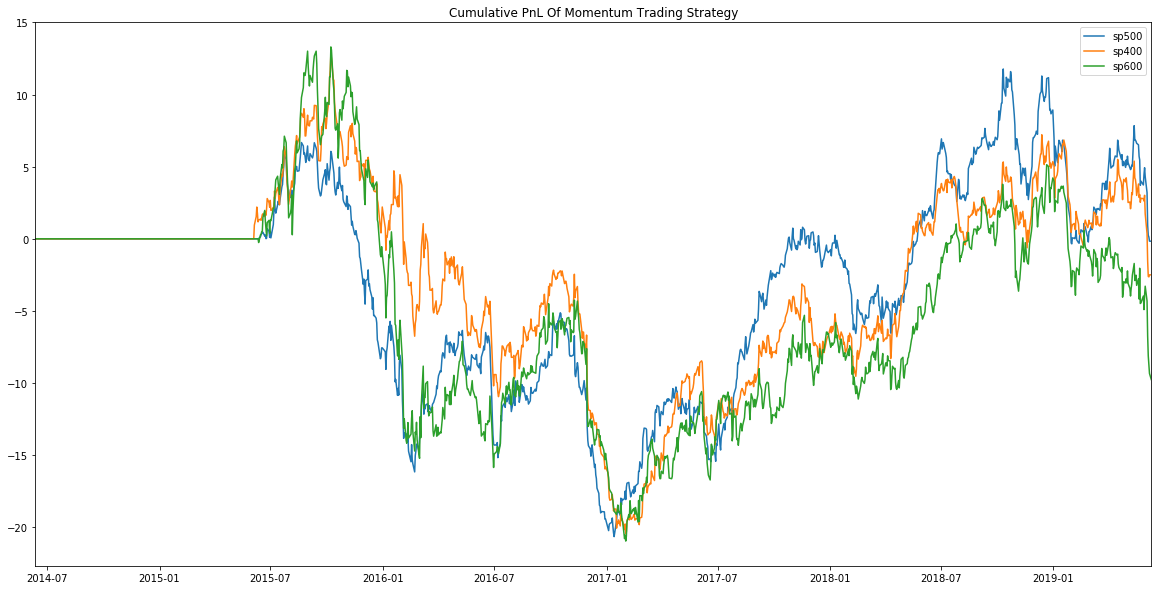

In [22]:
# Set size
plt.figure(figsize=(20, 10))

for i in range(len(keys)):
    plt.plot(pnl_strat[keys[i]].cumsum())
    
plt.xlim(pnl_strat['sp500'].index[0], pnl_strat['sp500'].index[-1])
# plt.ylim(-10, 5)

# Set title and legend
plt.title('Cumulative PnL Of Momentum Trading Strategy')
plt.legend(keys)

Remarks: 
1. From July 2015 to January 2017, the momentum trading strategy generated negative PnL.
2. From July 2017 to January 2019, the momentum trading strategy turned it around and generated positive PnL.
3. From January 2019, the momentum trading strategy continuted to generate positive PnL for S&P 500 and S&P 400 MidCap indices only. 

## Conclusion
In this article, we implemented a momentum trading strategy based on principal component analysis.
The momentum trading strategy generated positive PnL from July 2017 to January 2019, and negative PnL from July 2015 to July 2017.
A way to enhance the current momentum trading strategy is to include exit and entry points depending on the expected profitability of the trading system.